In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# Find Best Paths Between ODs

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')

from quetzal.model import stepmodel
import os
import pandas as pd
if manual:
    %matplotlib inline

PyTables is not installed. No support for HDF output.


In [3]:
training_folder = '../../'

# Read model

In [4]:
sm = stepmodel.read_zippedpickles(training_folder + r'models/{scen}/walk_model'.format(scen='base'))

zone_to_transit: 100%|██████████| 29/29 [00:01<00:00, 25.53it/s]


# Preparation
average speed on road_links

In [5]:
bus = sm.links.loc[sm.links['route_type'] == 'bus']
bus_lines = bus.groupby('route_id')[['time', 'road_length']].sum()
bus_speed = bus['road_length'].sum() / bus['time'].sum() # operation speed
print('bus_speed =', bus_speed, 'm / s')

bus_speed = 3.5803334741653963 m / s


In [6]:
# pt
sm.links['headway'] = 300
sm.links['length'] = sm.links['road_length']

# road
car_speed = bus_speed * 1.25
sm.road_links['time'] = sm.road_links['length'] / car_speed # m/s

# walk
sm.road_links['walk_time'] = sm.road_links['time'] * 3 # walk three times slower than car

# PT PATHFINDER
## walk on road
people walk on the road network, slow computation

In [7]:
wor = sm.copy()
wor.step_pt_pathfinder(broken_modes=False, broken_routes=False, walk_on_road=True)

start publicpathfinder
path_analysis


path_analysis: 100%|██████████| 12100/12100 [00:00<00:00, 40199.07it/s]


## as the crow flies
people walk on dedicated access and egress links only

In [8]:
acf = sm.copy()
acf.step_pt_pathfinder(broken_modes=False, broken_routes=False)

start publicpathfinder
path_analysis


path_analysis: 100%|██████████| 12100/12100 [00:00<00:00, 46177.27it/s]


In [9]:
# here we chose to use the ACF paths
sm.pt_los = acf.pt_los

# ROAD PATHFINDER

In [10]:
sm.step_road_pathfinder(method = 'aon')
sm.car_los.drop(columns=['gtime'], inplace=True)

self.volumes does not exist. od generated with self.zones


# Export

In [11]:
sm.to_zippedpickles(training_folder + 'models/{scen}/aon_pathfinder'.format(scen=scenario))  

  0%|          | 0/31 [00:00<?, ?it/s]

car_los: 100%|██████████| 31/31 [00:03<00:00, 10.07it/s]                  


In [ ]:
end_of_notebook

# PLOT

<AxesSubplot: xlabel='gtime', ylabel='time'>

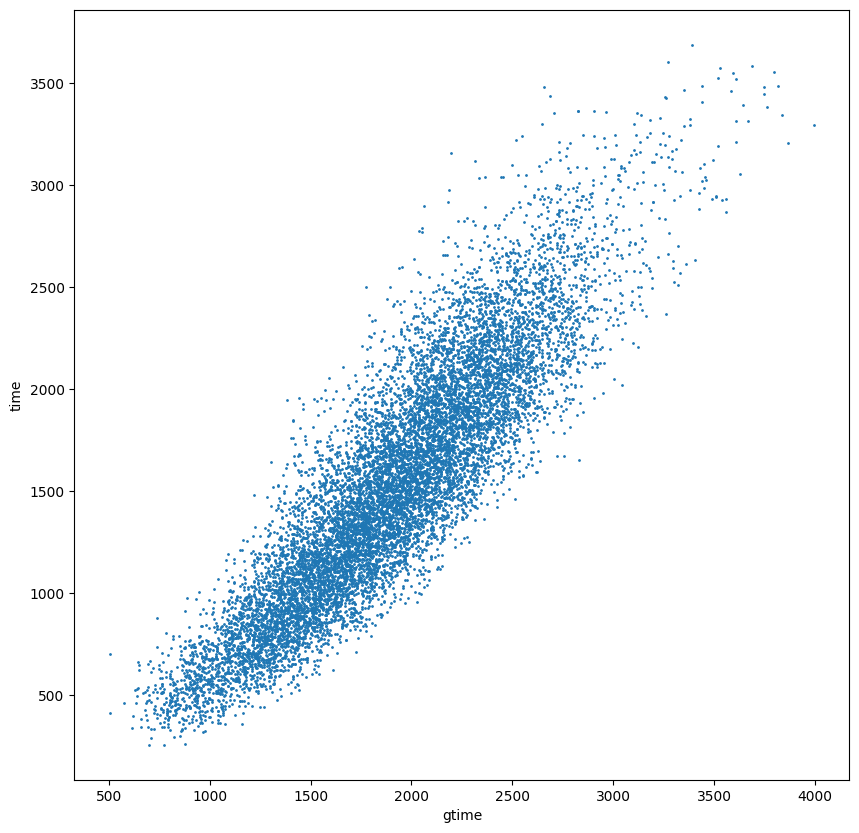

In [13]:
los = pd.merge(sm.pt_los, sm.car_los, on=['origin', 'destination'], suffixes=['_pt', '_car'])
los = los.loc[los['origin'] != los['destination']]
los.plot(kind='scatter', x='gtime', y='time', figsize=[10, 10], s=1)

# END